In [1]:
#import required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
from skimage.feature import match_template
import numpy as np
from PIL import Image

ModuleNotFoundError: No module named 'geopandas'

In [2]:
#open point shapefile
pointData = gpd.read_file('Shp/pointData.shp')
print('CRS of Point Data: ' + str(pointData.crs))

#open raster file
palmRaster = rasterio.open('Rst/palmaOrthoTotal_14cm.tif')
print('CRS of Raster Data: ' + str(palmRaster.crs))
print('Number of Raster Bands: ' + str(palmRaster.count))
print('Interpretation of Raster Bands: ' + str(palmRaster.colorinterp))

NameError: name 'gpd' is not defined

NameError: name 'pointData' is not defined

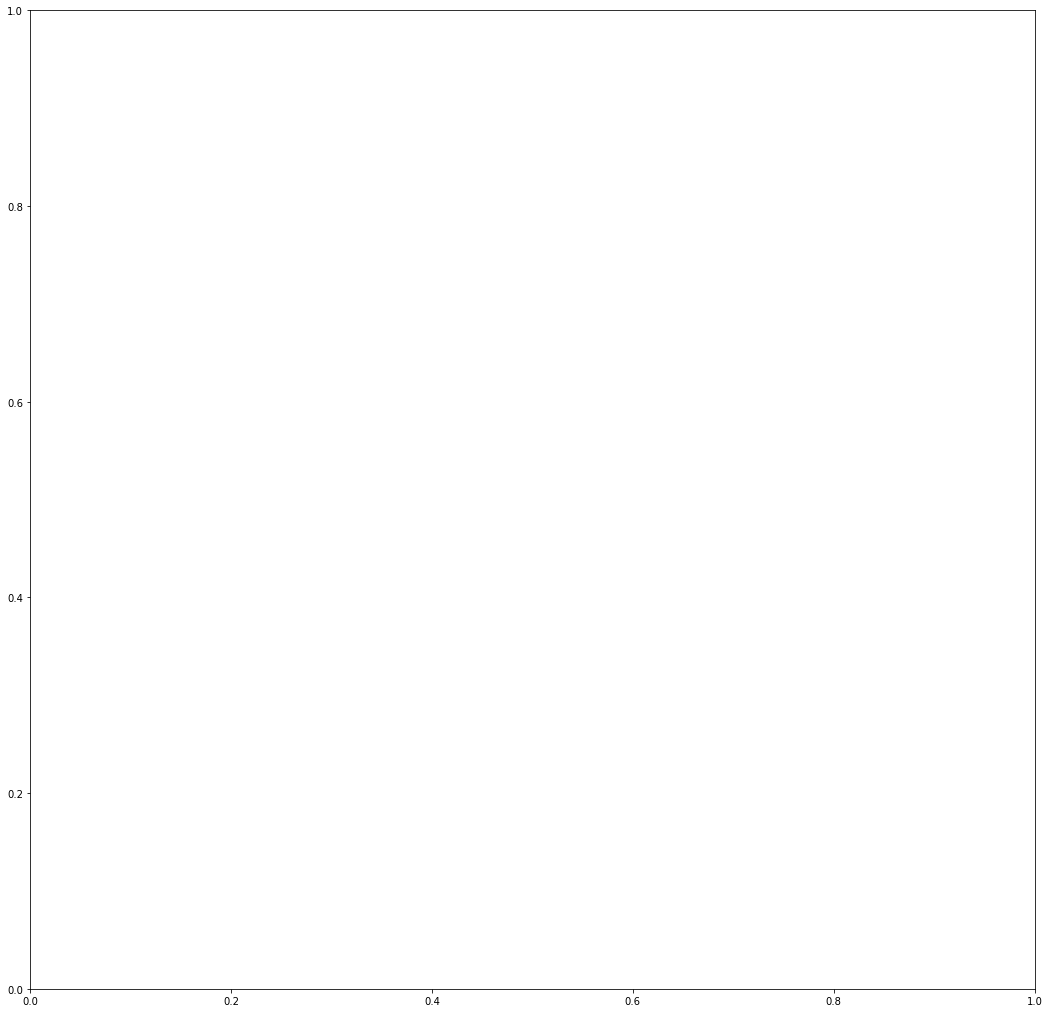

In [3]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(18,18))
pointData.plot(ax=ax, color='orangered', markersize=100)
show(palmRaster, ax=ax)

In [4]:
#selected band: green
greenBand = palmRaster.read(2)

NameError: name 'palmRaster' is not defined

In [5]:
#extract point value from raster
surveyRowCol = []
for index, values in pointData.iterrows():
    x = values['geometry'].xy[0][0]
    y = values['geometry'].xy[1][0]
    row, col = palmRaster.index(x,y)
    print("Point N°:%d corresponds to row, col: %d, %d"%(index,row,col))
    surveyRowCol.append([row,col])

NameError: name 'pointData' is not defined

In [6]:
# number of template images
print('Number of template images: %d'%len(surveyRowCol))
# define ratio of analysis
radio = 25

Number of template images: 0


In [7]:
#show all the points of interest, please be careful to have a complete image, otherwise the model wont run
fig, ax = plt.subplots(1, len(surveyRowCol),figsize=(20,5))

for index, item in enumerate(surveyRowCol):
    row = item[0]
    col = item[1]
    ax[index].imshow(greenBand)
    ax[index].plot(col,row,color='red', linestyle='dashed', marker='+',
     markerfacecolor='blue', markersize=8)
    ax[index].set_xlim(col-radio,col+radio)
    ax[index].set_ylim(row-radio,row+radio)
    ax[index].axis('off')
    ax[index].set_title(index)


ValueError: Number of columns must be a positive integer, not 0

<Figure size 1440x360 with 0 Axes>

In [8]:
# Match the image to the template

listaresultados = []

templateBandList = []
for rowCol in surveyRowCol:
    imageList = []
    row = rowCol[0]
    col = rowCol[1]
    #append original band
    imageList.append(greenBand[row-radio:row+radio, col-radio:col+radio])
    #append rotated images
    templateBandToRotate = greenBand[row-2*radio:row+2*radio, col-2*radio:col+2*radio]
    rotationList = [i*30 for i in range(1,4)]
    for rotation in rotationList:
        rotatedRaw = Image.fromarray(templateBandToRotate)
        rotatedImage = rotatedRaw.rotate(rotation)
        imageList.append(np.asarray(rotatedImage)[radio:-radio,radio:-radio])
    #plot original and rotated images
    fig, ax = plt.subplots(1, len(imageList),figsize=(12,12))
    for index, item in enumerate(imageList):
        ax[index].imshow(imageList[index])
    #add images to total list
    templateBandList+=imageList

In [9]:
# match the template image to the orthophoto
matchXYList = []
for index, templateband in enumerate(templateBandList):
    if index%10 == 0:
        print('Match template ongoing for figure Nº %d'%index)
    matchTemplate = match_template(greenBand, templateband, pad_input=True)
    matchTemplateFiltered = np.where(matchTemplate>np.quantile(matchTemplate,0.9996))
    for item in zip(matchTemplateFiltered[0],matchTemplateFiltered[1]):
        x, y = palmRaster.xy(item[0], item[1])
        matchXYList.append([x,y])

NameError: name 'np' is not defined

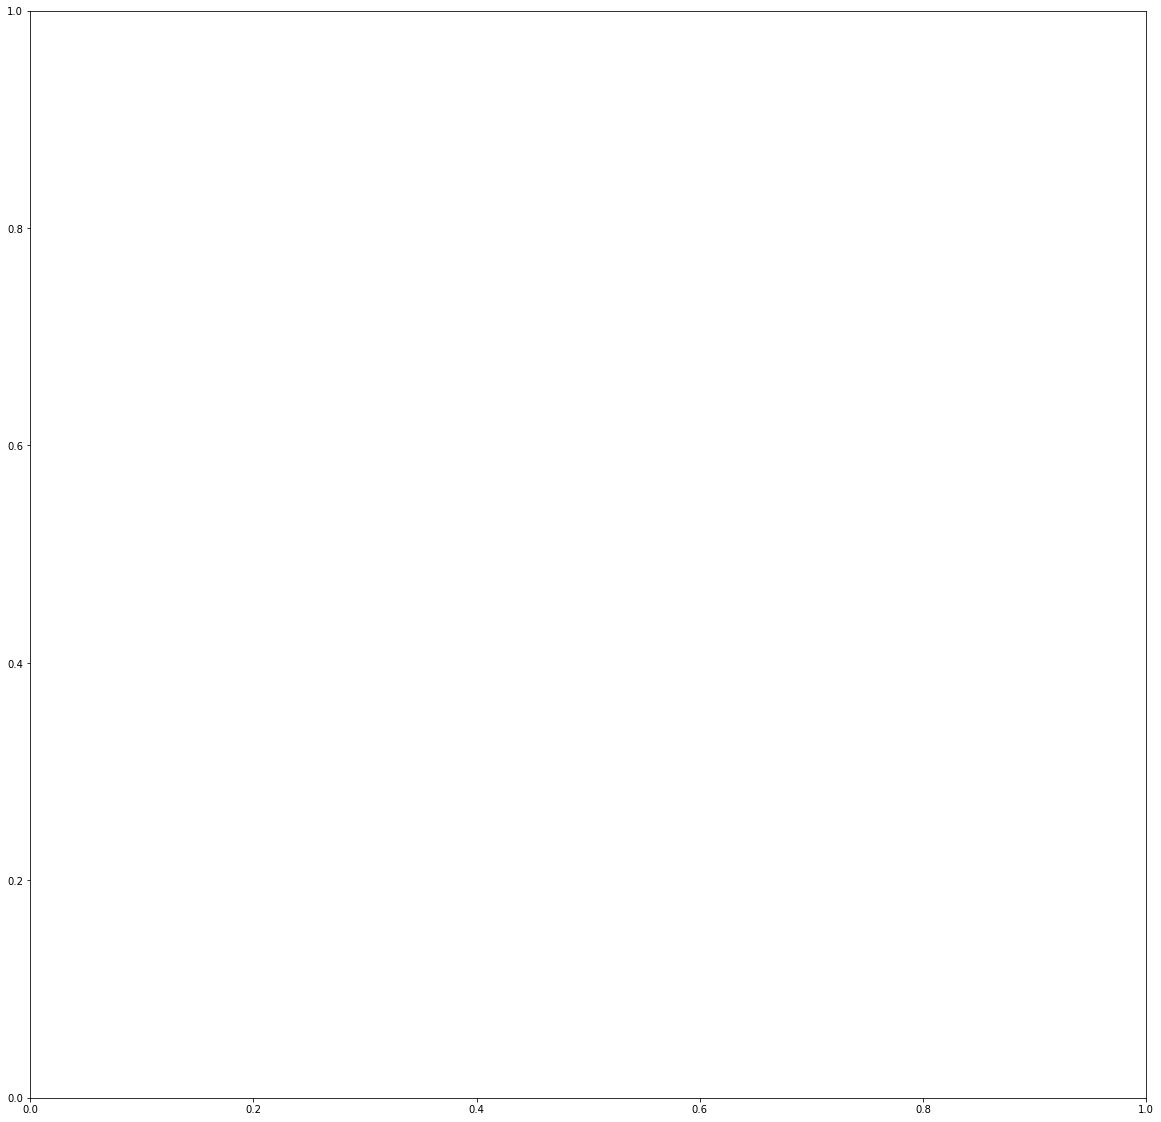

In [10]:
# plot interpreted points over the image
fig, ax = plt.subplots(figsize=(20, 20))
matchXYArray = np.array(matchXYList)
ax.scatter(matchXYArray[:,0],matchXYArray[:,1], marker='o',c='orangered', s=100, alpha=0.25)
show(palmRaster, ax=ax)

In [11]:
# cluster analysis
from sklearn.cluster import Birch
brc = Birch(branching_factor=10000, n_clusters=None, threshold=2e-5, compute_labels=True)
brc.fit(matchXYArray)
birchPoint = brc.subcluster_centers_
birchPoint

NameError: name 'matchXYArray' is not defined

NameError: name 'birchPoint' is not defined

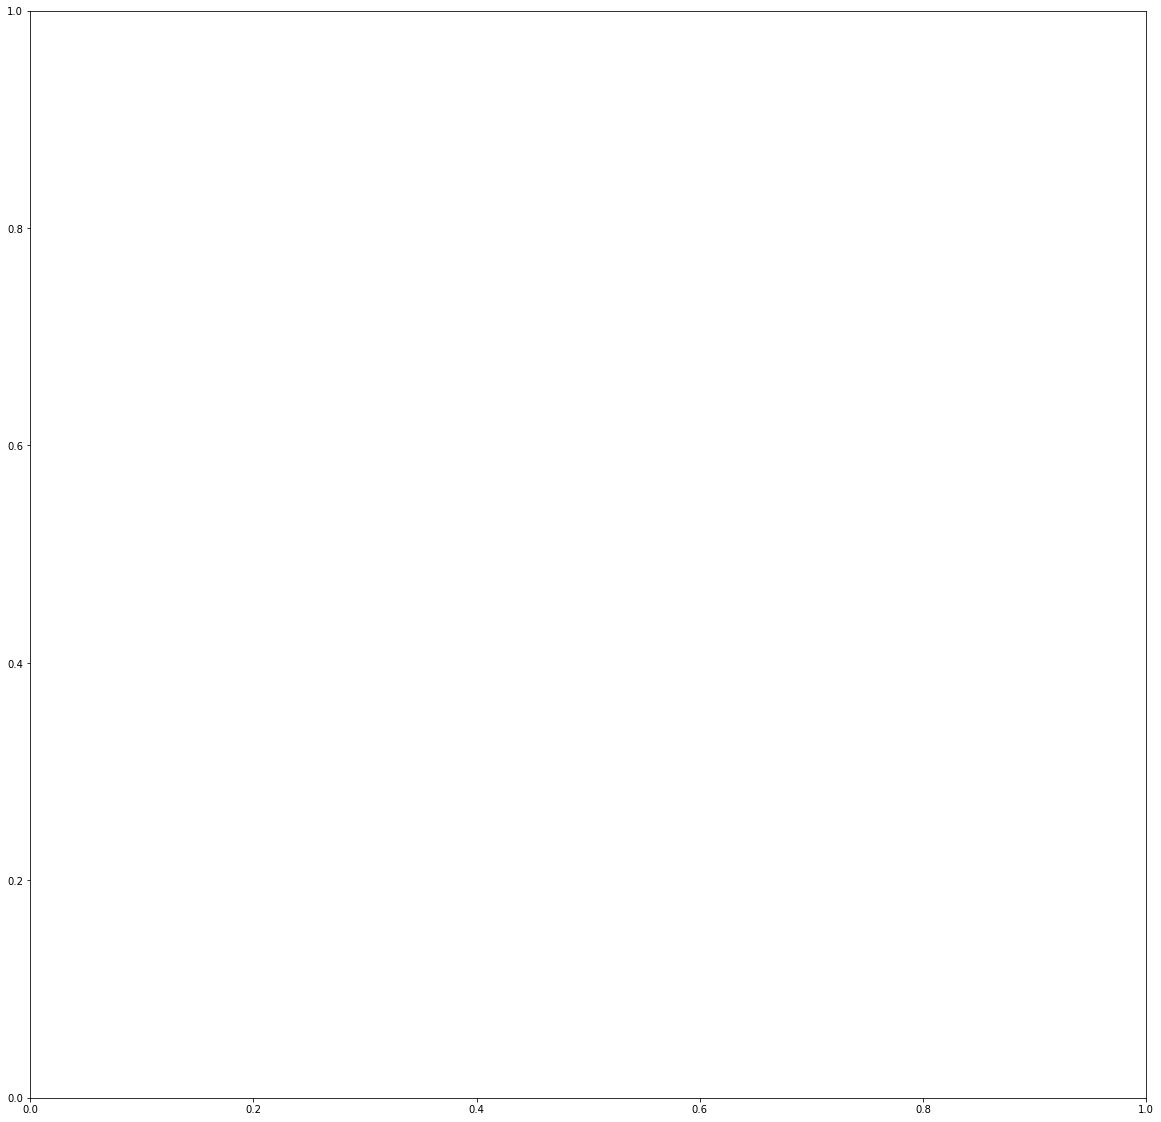

In [12]:
# plot clustered points
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.scatter(birchPoint[:,[0]],birchPoint[:,[1]], marker='o',color='orangered',s=100)
show(palmRaster, ax=ax)
plt.show()

In [10]:
# save xy to a csv file
np.savetxt("Txt/birchPoints.csv", birchPoint, delimiter=",")

NameError: name 'np' is not defined